In [1]:
import json
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.signal import argrelextrema, peak_prominences

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [3]:
# Load Data
df = pd.read_json('dataset.json', orient='records')

In [4]:
# Get basic info about data (types, count, fields)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   wn_interpolated        1920 non-null   object
 1   spectrum_interpolated  1920 non-null   object
 2   glucose                1920 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 45.1+ KB


In [5]:
# Get a sneak peek
df.head()

,wn_interpolated,spectrum_interpolated,glucose
0,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0054450321, 0.0050841617, 0.0047476634, 0.0...",180
1,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0051177328, 0.004855426, 0.0046091433, 0.00...",160
2,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0018736758, 0.0021172502000000003, 0.002357...",90
3,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0019114823, 0.001861196, 0.0018255961000000...",90
4,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0034135354000000002, 0.0034606581, 0.003512...",110


# Introduction

Our goal is to find a relationship between the spectrum and glucose values. This is what machine learning is supposed to do - find a relationship between variables (input and target) so that we can make predictions on unseen data. 

What characterizes a spectrum are the peak positions and (relative) intensities, which makes every spectrum a unique fingerprint. One could argue that widths of the peaks are also important but for the analysis done in this work, we will not take that into account. The glucose levels are thus mainly related to peak positions and their relative intensities. Let's extract the peaks and turn them into input features. We will choose first five peaks. Why only first five? A visual inspection of 50 randomly selected spectra (see html plot report) from the dataset seems to indicate that there are mainly five important peaks. In addition, the glucose absorbance spectrum also seems to confirm this. 

In [6]:
# Convert Spectra to Numpy Array
df['wn_interpolated'] = df['wn_interpolated'].apply(lambda x: np.array(x))
df['spectrum_interpolated'] = df['spectrum_interpolated'].apply(lambda x: np.array(x))

In [7]:
# Rename column names
df.rename(columns = {'wn_interpolated':'frequency', 'spectrum_interpolated':'intensity'}, inplace = True)

# Feature selection

In [8]:
# Find Peaks and Create new data frame (all entires)
def create_features(input_df):
  
  # Make a deepcopy
  df_c = input_df.copy(deep=True)
  
  # Number of rows
  nrow = df_c.shape[0]
  
  # Initialize feature columns: 
  # f stands for frequencies, s for spectrum (intensities)
  f1 = []; s1 = []
  f2 = []; s2 = []
  f3 = []; s3 = []
  f4 = []; s4 = []
  f5 = []; s5 = []
  
  for row in df_c.itertuples():
    
    # Initilize peak frequencies
    # In the rare event that a spectrum has less than five
    # peaks, rest will be treated as zero
    peak_freq = np.empty(5) * np.nan
    peak_spec = np.empty(5) * np.nan
    
    # Find peaks
    freq = row.frequency
    spec = row.intensity
    peaks, _ = find_peaks(spec, distance=20)
    
    npeaks = len(peaks)
    
    # Assign
    if npeaks <= 5:
      peak_freq[:npeaks] = freq[peaks]
      peak_spec[:npeaks] = spec[peaks]
    else:
      peak_freq[:] = freq[peaks[:5]]
      peak_spec[:] = spec[peaks[:5]]
    
    f1.append(peak_freq[0])
    f2.append(peak_freq[1])
    f3.append(peak_freq[2])
    f4.append(peak_freq[3])
    f5.append(peak_freq[4])
    
    s1.append(peak_spec[0])
    s2.append(peak_spec[1])
    s3.append(peak_spec[2])
    s4.append(peak_spec[3])
    s5.append(peak_spec[4])
  
  # New data frame
  df_new = pd.DataFrame(
    {'f1': f1,
     'f2': f2,
     'f3': f3,
     'f4': f4,
     'f5': f5,
     's1': s1,
     's2': s2,
     's3': s3,
     's4': s4,
     's5': s5,
     'glucose': df_c.glucose
    })
  
  return df_new
    

In [10]:
# Create new DataFrame
full_df = create_features(df)

In [11]:
full_df.isna().sum()

f1           0
f2           0
f3           0
f4           3
f5         198
s1           0
s2           0
s3           0
s4           3
s5         198
glucose      0
dtype: int64

# Summary/EDA of new data frame

In [12]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
f1,1920.0,986.325000,19.566421,951.000000,972.000000,990.000000,994.000000,1081.000000
f2,1920.0,1034.569792,26.061304,979.000000,1018.000000,1036.000000,1052.000000,1117.000000
f3,1920.0,1074.885937,22.868453,1013.000000,1056.000000,1082.000000,1083.000000,1173.000000
f4,1917.0,1109.379238,26.862591,1038.000000,1083.000000,1108.000000,1116.000000,1174.000000
f5,1722.0,1146.591754,29.005680,1080.000000,1118.000000,1170.000000,1172.000000,1175.000000
s1,1920.0,0.003671,0.001016,0.001276,0.002929,0.003579,0.004360,0.007606
s2,1920.0,0.004893,0.001421,0.001539,0.003941,0.004962,0.005913,0.008892
s3,1920.0,0.005849,0.001246,0.002573,0.004941,0.005819,0.006745,0.009109
s4,1917.0,0.006211,0.001189,0.002839,0.005268,0.006211,0.007116,0.009492
s5,1722.0,0.006291,0.001239,0.003837,0.005258,0.006180,0.007253,0.009952


It's interesting to note that the mean values of the selected peak positions are in close alignment with the actual glucose spectrum peak positions. The relative intensity pattern is not quite the same, which is to be expected. There are some outliers (also to be seen in the box plot below) and some issues with the data which we will deal with later on.

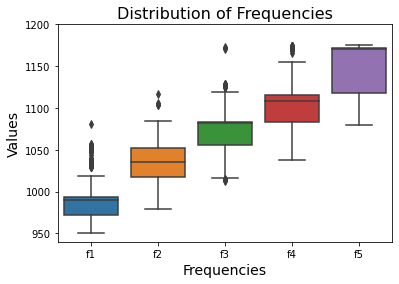

In [77]:
# Box plot for selected 5 Frequencies
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(full_df[['f1','f2','f3','f4','f5']]))
boxplot.axes.set_title("Distribution of Frequencies", fontsize=16)
boxplot.set_xlabel("Frequencies", fontsize=14)
boxplot.set_ylabel("Values", fontsize=14)
boxplot.set_ylim(940,1200)
plt.show()

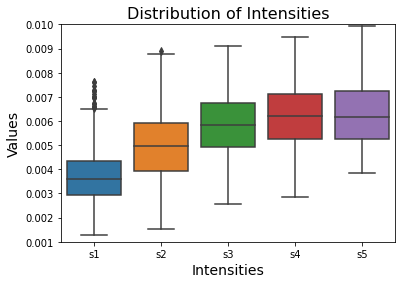

In [78]:
# Box plot for Intensities
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(full_df[['s1','s2','s3','s4','s5']]))
boxplot.axes.set_title("Distribution of Intensities", fontsize=16)
boxplot.set_xlabel("Intensities", fontsize=14)
boxplot.set_ylabel("Values", fontsize=14)
boxplot.set_ylim(0.001,0.01)
plt.show()

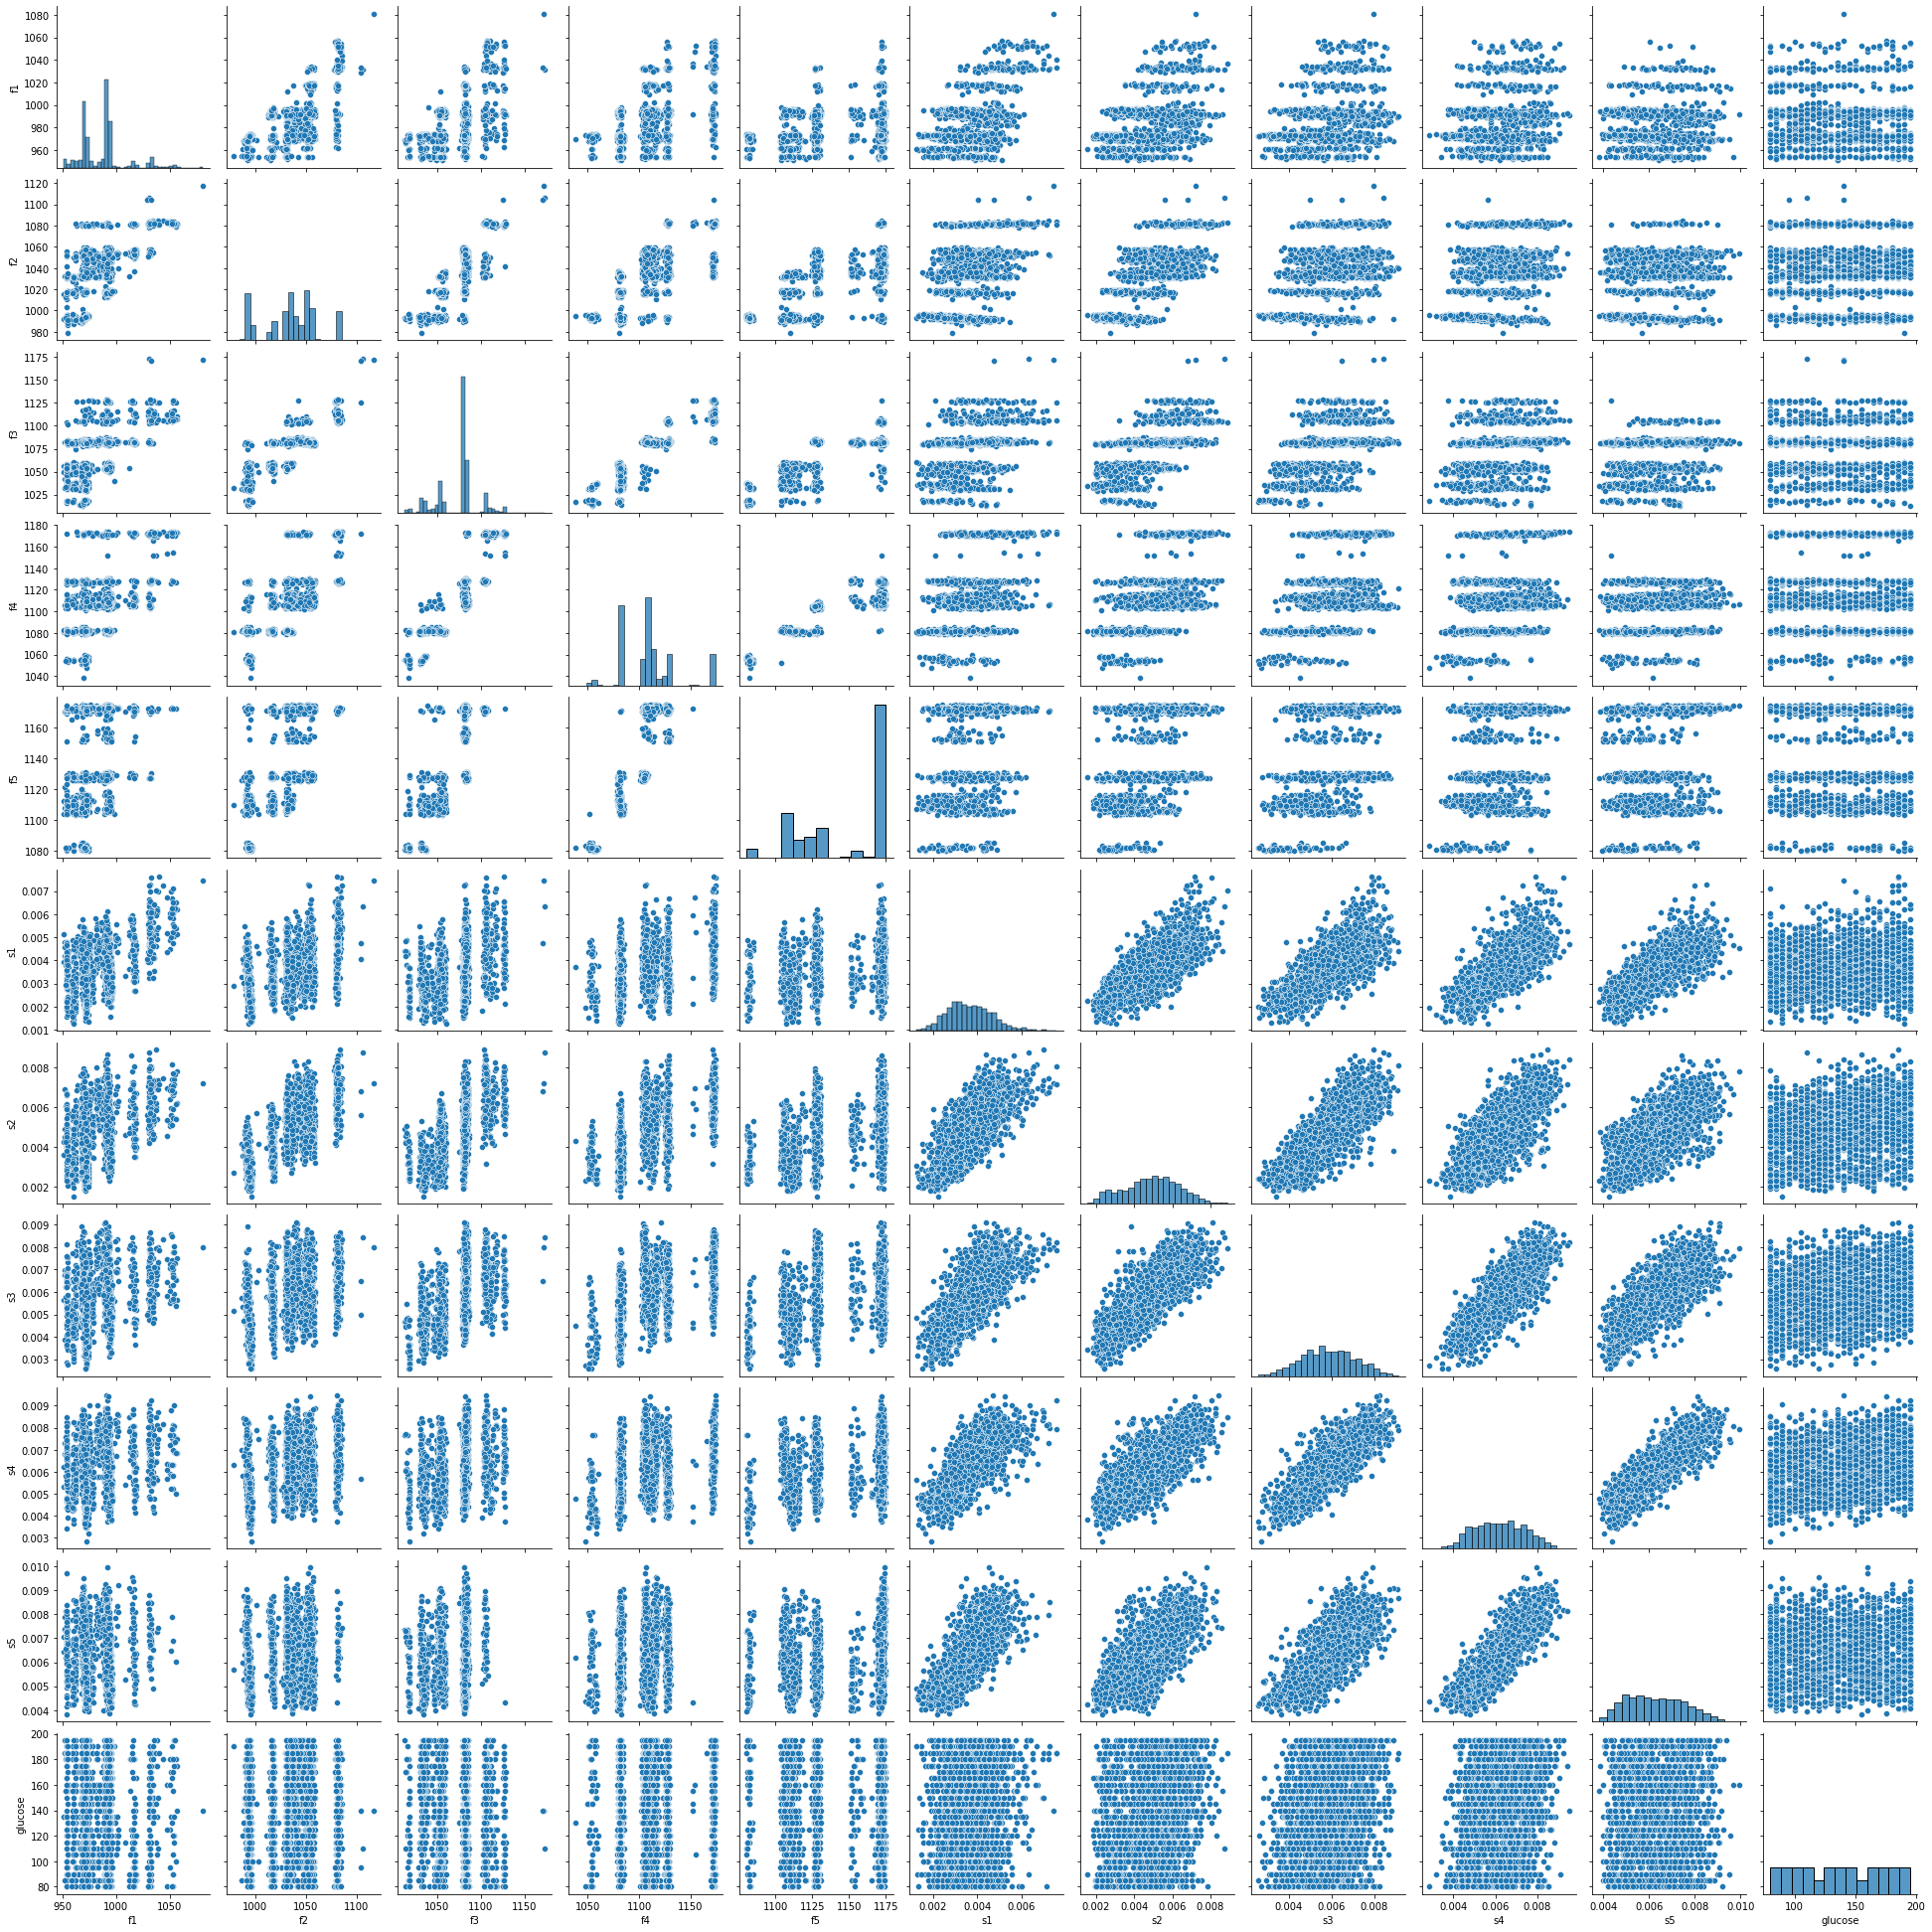

In [26]:
# Let's try to visualize xorrelation between variables 
sns.pairplot(full_df)

The pairplot is, well, all over the place. It seems that the features individually are not very well correlated with the glucose values at all! Perhaps some combination of these features (such as a weighted sum of frequencies) is a better input to learn the relationship with the glucose values (target variable). This kind of feature engineering depends on intution and domain knowledge. Nonetheless, we can perform some tricks, or just brute force use all the variables since we have already reduced them to only ten!

We can try to reduce number of input features or find the important features by methods like principal component analysis (PCA) or partial least regression (PLS). Let's also do a simple linear regression using all 10 input variables.

Let's also remove the NaNs and make our life simpler.

In [13]:
# Drop NaN
full_df = full_df.dropna()

In [14]:
# SUmmary staistics after dropping NaN
summary_stats = full_df.describe().T

In [15]:
summary_stats

,count,mean,std,min,25%,50%,75%,max
f1,1722.0,983.260743,15.739267,951.000000,971.000000,989.000000,993.000000,1056.000000
f2,1722.0,1030.167828,23.100549,979.000000,1016.000000,1035.000000,1050.000000,1085.000000
f3,1722.0,1070.501161,19.489393,1013.000000,1055.000000,1081.000000,1082.000000,1128.000000
f4,1722.0,1102.355401,17.808532,1038.000000,1082.000000,1107.000000,1113.000000,1152.000000
f5,1722.0,1146.591754,29.005680,1080.000000,1118.000000,1170.000000,1172.000000,1175.000000
s1,1722.0,0.003563,0.000938,0.001276,0.002889,0.003494,0.004234,0.007298
s2,1722.0,0.004732,0.001371,0.001539,0.003784,0.004789,0.005748,0.008595
s3,1722.0,0.005746,0.001222,0.002573,0.004858,0.005690,0.006607,0.009109
s4,1722.0,0.006135,0.001168,0.002839,0.005203,0.006112,0.007000,0.009430
s5,1722.0,0.006291,0.001239,0.003837,0.005258,0.006180,0.007253,0.009952


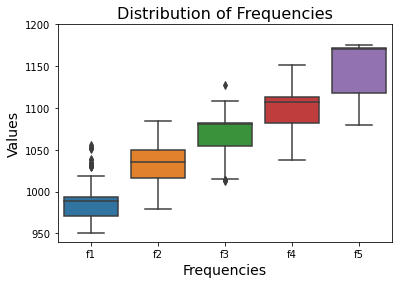

In [82]:
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(full_df[['f1','f2','f3','f4','f5']]))
boxplot.axes.set_title("Distribution of Frequencies", fontsize=16)
boxplot.set_xlabel("Frequencies", fontsize=14)
boxplot.set_ylabel("Values", fontsize=14)
boxplot.set_ylim(940,1200)
plt.show()

# Create training and test set

In [16]:
# Separate input from target
X = full_df.iloc[:,:-1]

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, full_df['glucose'], random_state=0)


# MARD

In [19]:
def calc_mard(y_ref, y_pred):
  
  ''' Calculate MARD to check accuracy of the model'''
  
  mard = np.mean(np.abs(y_pred - y_ref)/y_ref)
  
  return mard

# Linear Regression / Partial Least Regression

In [20]:
# Let's test some basic models

# Linear Regression
mlr = make_pipeline(StandardScaler(), PCA(n_components=10), LinearRegression())
mlr.fit(X_train, y_train)

# Partial Least Regression
pls = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
pls.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('plsregression', PLSRegression(n_components=5))])

In [21]:
# MARD
y_mlr = mlr.predict(X_test)
mard_mlr = calc_mard(y_test, y_mlr)
y_pls = pls.predict(X_test).flatten()
mard_pls = calc_mard(y_test, y_pls)

In [23]:
print(f"MLR MARD {mard_mlr:.3f}")
print(f"PLS MARD {mard_pls:.3f}")

MLR MARD 0.206
PLS MARD 0.206


In [22]:
# R^2
print(f"MLR r-squared {mlr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

MLR r-squared 0.297
PLS r-squared 0.297


These results are disappointing, but it's a start. Let's do some visualization of our predictions. Also note that PLS manages to achieve the same accuracy as linear regression with only half the input variables.

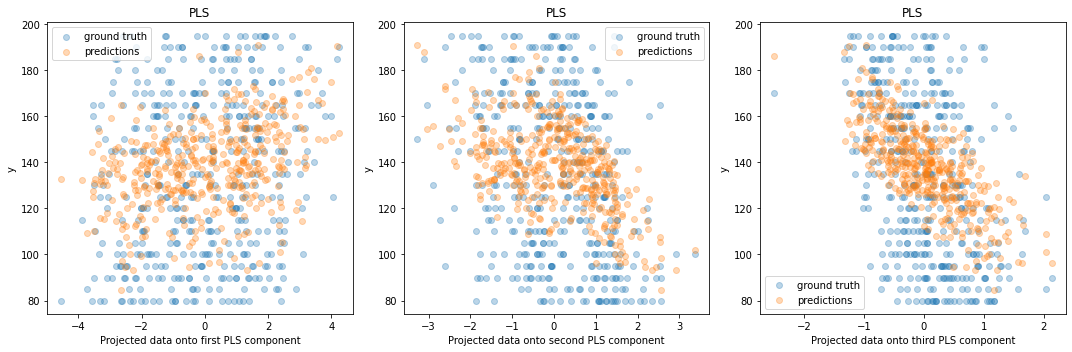

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(pls.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pls.transform(X_test)[:,0], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PLS component", ylabel="y", title="PLS"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test)[:,1], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto second PLS component", ylabel="y", title="PLS")
axes[1].legend()
axes[2].scatter(pls.transform(X_test)[:,2], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(
    pls.transform(X_test)[:,2], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[2].set(xlabel="Projected data onto third PLS component", ylabel="y", title="PLS")
axes[2].legend()
plt.tight_layout()
plt.show()

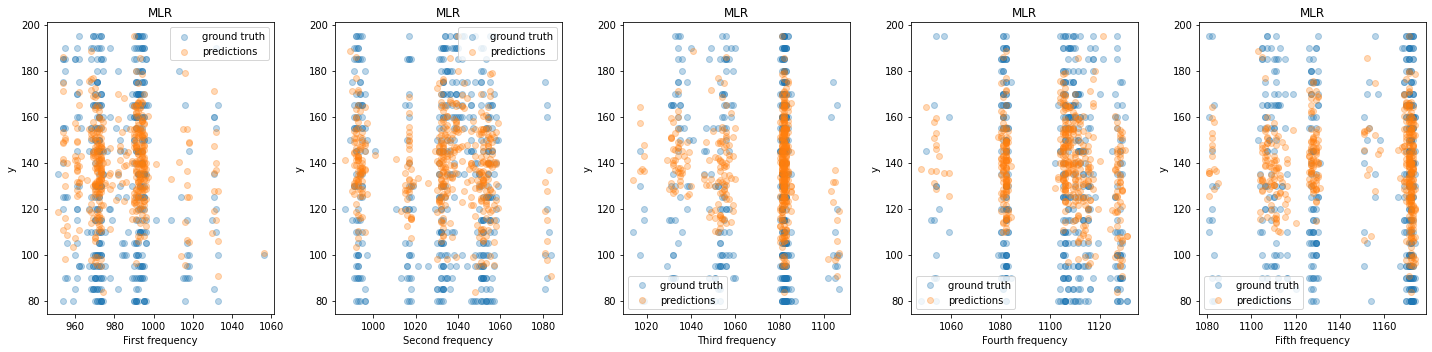

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].scatter(X_test['f1'], y_test, alpha=0.3, label="ground truth")
ax[0].scatter(
    X_test['f1'], mlr.predict(X_test), alpha=0.3, label="predictions"
)
ax[0].set(xlabel="First frequency", ylabel="y", title="MLR")
ax[0].legend()
ax[1].scatter(X_test['f2'], y_test, alpha=0.3, label="ground truth")
ax[1].scatter(
    X_test['f2'], mlr.predict(X_test), alpha=0.3, label="predictions"
)
ax[1].set(xlabel="Second frequency", ylabel="y", title="MLR")
ax[1].legend()
ax[2].scatter(X_test['f3'], y_test, alpha=0.3, label="ground truth")
ax[2].scatter(
    X_test['f3'], mlr.predict(X_test), alpha=0.3, label="predictions"
)
ax[2].set(xlabel="Third frequency", ylabel="y", title="MLR")
ax[2].legend()
ax[3].scatter(X_test['f4'], y_test, alpha=0.3, label="ground truth")
ax[3].scatter(
    X_test['f4'], mlr.predict(X_test), alpha=0.3, label="predictions"
)
ax[3].set(xlabel="Fourth frequency", ylabel="y", title="MLR")
ax[3].legend()
ax[4].scatter(X_test['f5'], y_test, alpha=0.3, label="ground truth")
ax[4].scatter(
    X_test['f5'], mlr.predict(X_test), alpha=0.3, label="predictions"
)
ax[4].set(xlabel="Fifth frequency", ylabel="y", title="MLR")
ax[4].legend()
plt.tight_layout()
plt.show()

Needless to say, these MLR and PLS predictions are not so good. Let's try support vector machines (SVM) and see if that improves our predictions.

# Support Vector Machine

In [25]:
# Support Vector Regression
svr = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))
svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, gamma=0.1))])

In [26]:
# Model evaluation on training set
print(f"SVR r-squared {svr.score(X_train, y_train):.3f}")
print(f"SVR MARD {calc_mard(y_train, svr.predict(X_train)):.3f}")

SVR r-squared 0.484
SVR MARD 0.144


In [27]:
# Model evaluation on test set
print(f"SVR r-squared {svr.score(X_test, y_test):.3f}")
print(f"SVR MARD {calc_mard(y_test, svr.predict(X_test)):.3f}")

SVR r-squared 0.381
SVR MARD 0.188


SVR does seem to have improved the predictions, though the performance still remains poor. Let's visualize the predictions against ground truth.

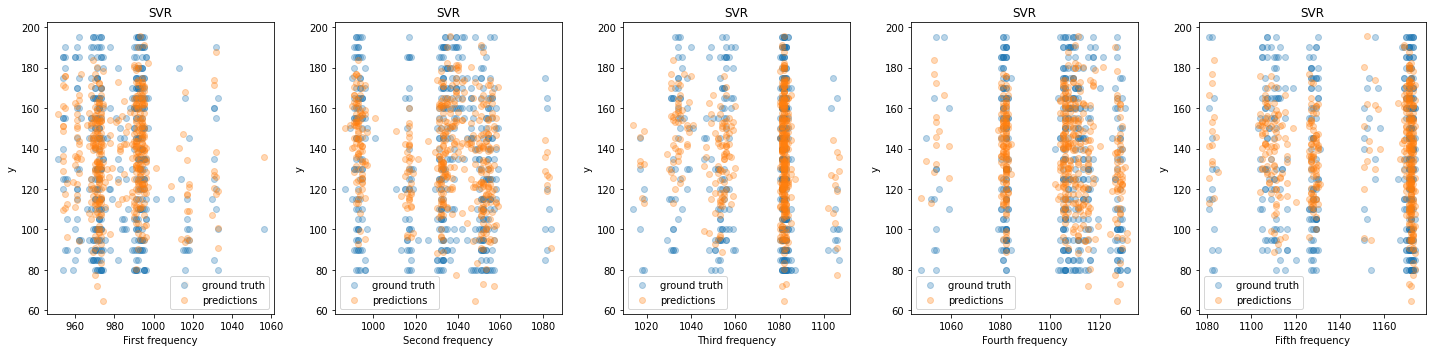

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].scatter(X_test['f1'], y_test, alpha=0.3, label="ground truth")
ax[0].scatter(
    X_test['f1'], svr.predict(X_test), alpha=0.3, label="predictions"
)
ax[0].set(xlabel="First frequency", ylabel="y", title="SVR")
ax[0].legend()
ax[1].scatter(X_test['f2'], y_test, alpha=0.3, label="ground truth")
ax[1].scatter(
    X_test['f2'], svr.predict(X_test), alpha=0.3, label="predictions"
)
ax[1].set(xlabel="Second frequency", ylabel="y", title="SVR")
ax[1].legend()
ax[2].scatter(X_test['f3'], y_test, alpha=0.3, label="ground truth")
ax[2].scatter(
    X_test['f3'], svr.predict(X_test), alpha=0.3, label="predictions"
)
ax[2].set(xlabel="Third frequency", ylabel="y", title="SVR")
ax[2].legend()
ax[3].scatter(X_test['f4'], y_test, alpha=0.3, label="ground truth")
ax[3].scatter(
    X_test['f4'], svr.predict(X_test), alpha=0.3, label="predictions"
)
ax[3].set(xlabel="Fourth frequency", ylabel="y", title="SVR")
ax[3].legend()
ax[4].scatter(X_test['f5'], y_test, alpha=0.3, label="ground truth")
ax[4].scatter(
    X_test['f5'], svr.predict(X_test), alpha=0.3, label="predictions"
)
ax[4].set(xlabel="Fifth frequency", ylabel="y", title="SVR")
ax[4].legend()
plt.tight_layout()
plt.show()

We know that the spectra given are noisy, and the peak extraction procedure invariably misidentifies some peaks. We can try to clean this up by taking hints from the actual glucose absorbance spectrum and remove some of the "outliers". Hopefully, that will lead to a better model performance.

# Removing Outliers

In [29]:
# Create a copy of the data frame to work with
full_df_copy = full_df.copy()

In [30]:
# Summary statistics
full_df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
f1,1722.0,983.260743,15.739267,951.000000,971.000000,989.000000,993.000000,1056.000000
f2,1722.0,1030.167828,23.100549,979.000000,1016.000000,1035.000000,1050.000000,1085.000000
f3,1722.0,1070.501161,19.489393,1013.000000,1055.000000,1081.000000,1082.000000,1128.000000
f4,1722.0,1102.355401,17.808532,1038.000000,1082.000000,1107.000000,1113.000000,1152.000000
f5,1722.0,1146.591754,29.005680,1080.000000,1118.000000,1170.000000,1172.000000,1175.000000
s1,1722.0,0.003563,0.000938,0.001276,0.002889,0.003494,0.004234,0.007298
s2,1722.0,0.004732,0.001371,0.001539,0.003784,0.004789,0.005748,0.008595
s3,1722.0,0.005746,0.001222,0.002573,0.004858,0.005690,0.006607,0.009109
s4,1722.0,0.006135,0.001168,0.002839,0.005203,0.006112,0.007000,0.009430
s5,1722.0,0.006291,0.001239,0.003837,0.005258,0.006180,0.007253,0.009952


In [33]:
# Cleaning of first frequency
index = full_df_copy[(full_df_copy['f1'] > 1000) | (full_df_copy['f1'] < 960)].index
full_df_copy.drop(index, inplace=True)

In [34]:
# Cleaning of third frequency
index = full_df_copy[(full_df_copy['f3'] > 1100) | (full_df_copy['f3'] < 1040)].index
full_df_copy.drop(index, inplace=True)

In [35]:
full_df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
f1,1333.0,983.977494,10.928423,960.000000,972.000000,991.000000,993.000000,1000.000000
f2,1333.0,1034.483121,18.090672,989.000000,1031.000000,1036.000000,1050.000000,1059.000000
f3,1333.0,1075.501875,12.155006,1040.000000,1080.000000,1082.000000,1082.000000,1087.000000
f4,1333.0,1105.631658,14.407418,1079.000000,1104.000000,1107.000000,1114.000000,1131.000000
f5,1333.0,1151.741935,25.885362,1103.000000,1127.000000,1171.000000,1172.000000,1175.000000
s1,1333.0,0.003586,0.000840,0.001276,0.002961,0.003540,0.004203,0.006125
s2,1333.0,0.004940,0.001231,0.001931,0.004138,0.004976,0.005802,0.008291
s3,1333.0,0.005913,0.001138,0.003128,0.005058,0.005875,0.006689,0.009109
s4,1333.0,0.006225,0.001132,0.003607,0.005314,0.006233,0.007087,0.009430
s5,1333.0,0.006344,0.001222,0.003858,0.005350,0.006250,0.007326,0.009952


By imposing condition on first and third frequencies, we have already made the data set a lot better. The mean values are now very close those found in glucose absorbance spectrum. Let's see how the models perform now.

# Train test split on new data

In [36]:
# Separate input from target
X2 = full_df_copy.iloc[:,:-1]

In [37]:
# Train test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, full_df_copy['glucose'], random_state=42)


# SVM on new data

In [38]:
svr.fit(X_train_2, y_train_2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, gamma=0.1))])

In [39]:
# Model evaluation
print(f"SVR r-squared {svr.score(X_train_2, y_train_2):.3f}")
print(f"SVR MARD {calc_mard(y_train_2, svr.predict(X_train_2)):.3f}")

SVR r-squared 0.547
SVR MARD 0.133


In [40]:
# Model evaluation
print(f"SVR r-squared {svr.score(X_test, y_test):.3f}")
print(f"SVR MARD {calc_mard(y_test, svr.predict(X_test)):.3f}")

SVR r-squared 0.411
SVR MARD 0.163


Removal of outliers certainly improves the model performance, but not significantly. As our last shot, we will try gradient boosting through the XGBoost library.

# XGBoost

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [42]:
xgb = make_pipeline(StandardScaler(), XGBRegressor(n_estimators=1000, max_depth=20, eta=0.1, subsample=0.4, colsample_bytree=1.0))

In [43]:
xgb.fit(X_train_2, y_train_2)

[10:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(colsample_bytree=1.0, eta=0.1, max_depth=20,
                              n_estimators=1000, subsample=0.4))])

In [45]:
# Model evaluation
print(f"XGB r-squared {xgb.score(X_train_2, y_train_2):.3f}")
print(f"XGB MARD {calc_mard(y_train_2, xgb.predict(X_train_2)):.3f}")

XGB r-squared 1.000
XGB MARD 0.000


XGBoost performs miraculously well on teh trainig set. However, this is a well-known behaviour, and seems like a case of overfitting (similar to Laplacian Kernel in Kernel Ridge Regression). Let's evaluate the performance on the test set.

In [44]:
# Model evaluation
print(f"XGB r-squared {xgb.score(X_test, y_test):.3f}")
print(f"XGB MARD {calc_mard(y_test, xgb.predict(X_test)):.3f}")

XGB r-squared 0.665
XGB MARD 0.086


This starts to look somewhat respectable. Let's plot and see how it looks visually.

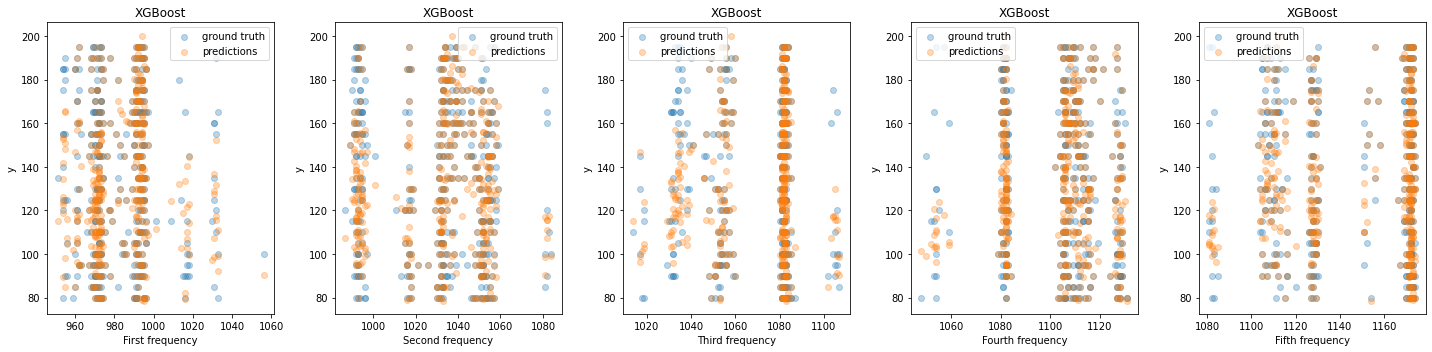

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].scatter(X_test['f1'], y_test, alpha=0.3, label="ground truth")
ax[0].scatter(
    X_test['f1'], xgb.predict(X_test), alpha=0.3, label="predictions"
)
ax[0].set(xlabel="First frequency", ylabel="y", title="XGBoost")
ax[0].legend()
ax[1].scatter(X_test['f2'], y_test, alpha=0.3, label="ground truth")
ax[1].scatter(
    X_test['f2'], xgb.predict(X_test), alpha=0.3, label="predictions"
)
ax[1].set(xlabel="Second frequency", ylabel="y", title="XGBoost")
ax[1].legend()
ax[2].scatter(X_test['f3'], y_test, alpha=0.3, label="ground truth")
ax[2].scatter(
    X_test['f3'], xgb.predict(X_test), alpha=0.3, label="predictions"
)
ax[2].set(xlabel="Third frequency", ylabel="y", title="XGBoost")
ax[2].legend()
ax[3].scatter(X_test['f4'], y_test, alpha=0.3, label="ground truth")
ax[3].scatter(
    X_test['f4'], xgb.predict(X_test), alpha=0.3, label="predictions"
)
ax[3].set(xlabel="Fourth frequency", ylabel="y", title="XGBoost")
ax[3].legend()
ax[4].scatter(X_test['f5'], y_test, alpha=0.3, label="ground truth")
ax[4].scatter(
    X_test['f5'], xgb.predict(X_test), alpha=0.3, label="predictions"
)
ax[4].set(xlabel="Fifth frequency", ylabel="y", title="XGBoost")
ax[4].legend()
plt.tight_layout()
plt.show()

# Final remarks

This is a premilinary analysis and leaves a lot to be desired. Some things that were not done, and could be explored, or just general dissatifaction with this analysis:

- All the hyperparameters have been fiddled with manually. A grid search or some other optimal procedure would be ideal.
- Some sort of cross-validation (such as 5-fold CV) would be good to carry out
- I'm still not sure if this is the ideal way of selecting the input features. Intutively it makes sense, but perhaps there are better ways to do this.
- A learning curve analysis can be performed to check the convergence of the optimal model and to get an idea how much data is enough for a converged model.